In [113]:
# Importamos las dependencias que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Bajamos el nivel de warning de TF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras import metrics

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score
from sklearn.utils import compute_class_weight

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
ROOT = 'D:/HDD_Documents/Universidad/En_curso/MachineLearning/CelebA'
IMAGES_DIR = Path(os.path.join(ROOT, 'img_align_celeba'))

In [4]:
df_attributes = pd.read_csv(os.path.join(ROOT,'list_attr_celeba.csv'))
df_attributes.set_index('image_id')

df_partition = pd.read_csv(os.path.join(ROOT, 'list_eval_partition.csv'))
df_partition.set_index('image_id')

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,2
202596.jpg,2
202597.jpg,2


In [5]:
full = pd.merge(df_attributes, df_partition)
full = full[['image_id', 'No_Beard', 'partition']]
full.set_index('image_id')

,No_Beard,partition
image_id,,
000001.jpg,1,0
000002.jpg,1,0
000003.jpg,1,0
000004.jpg,1,0
000005.jpg,1,0
...,...,...
202595.jpg,1,2
202596.jpg,1,2
202597.jpg,1,2


In [6]:
full.loc[full['No_Beard'] == -1, 'No_Beard'] = 0 # Pasamos a 0 y 1 la feature No_Beard
full['No_Beard'] = full['No_Beard'].astype(str) # Lo paso a string para que el datagen no me de error

In [7]:
len(os.listdir(IMAGES_DIR))

202599

In [8]:
extensions = set()
for filename in os.listdir(IMAGES_DIR):
    extensions.add(Path(filename).suffix.lower())
    
extensions

{'.jpg'}

In [9]:
img = image.load_img(os.path.join(IMAGES_DIR, '000001.jpg'))
img.size, image.img_to_array(img).shape[2]
# ((ancho, alto), canales)

((178, 218), 3)

In [10]:
# Tenemos 202599 imágenes, todas en formato jpg
# Ancho: 178px - Alto: 218px - Canales: 3 (RGB)
# Cada imagen tiene  40 atributos asociados a través del ID, solamente vamos a usar el atributo No_Beard

(162770, 3) (19867, 3) (19962, 3)


<Axes: ylabel='count'>

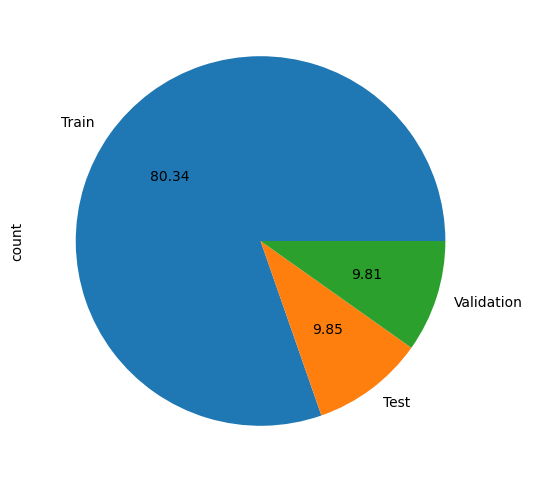

In [11]:
# Hacemos la separación en train, validation y test como se indica en el dataset 
df_train = full[full.partition == 0]
df_validation = full[full.partition == 1]
df_test = full[full.partition == 2]

print(df_train.shape, df_validation.shape, df_test.shape)
full.partition.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['Train', 'Test', 'Validation'])

<Axes: ylabel='count'>

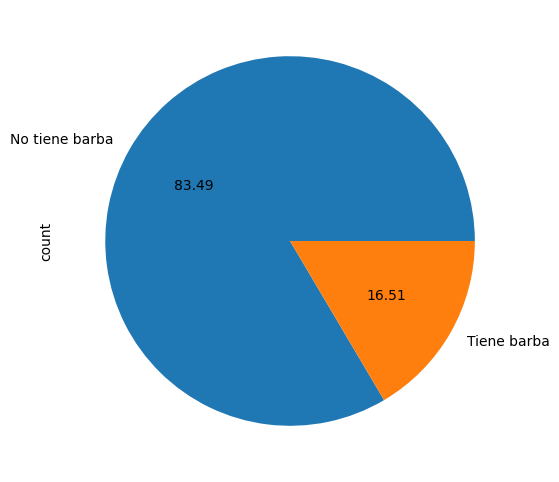

In [12]:
# Distribución en la totalidad del dataset
full.No_Beard.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['No tiene barba', 'Tiene barba'])

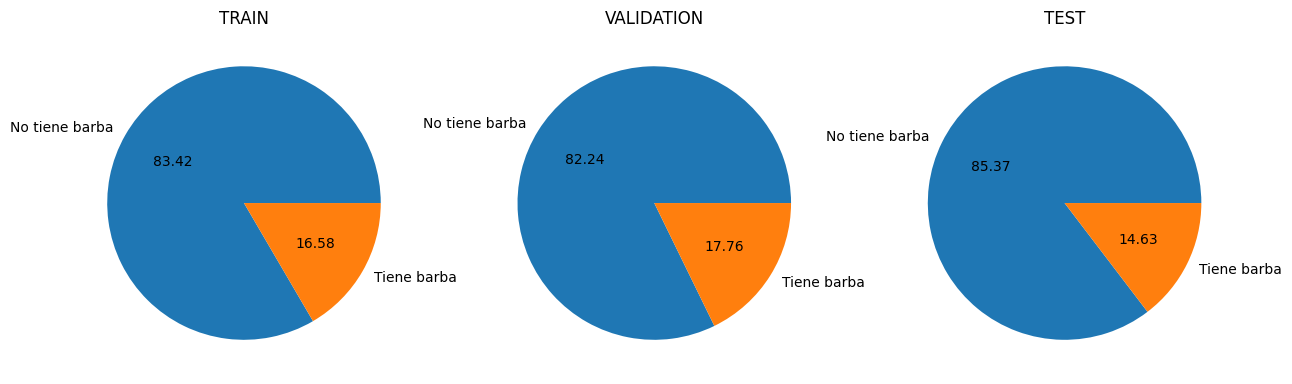

In [13]:
# Comparacion de la distribucion de 'No_Beard' en los tres subsets.
# Hacemos este análisis ya que no sabemos cómo hicieron la separación en los tres datasets,
# para ver si se mantiene la distribución de la variable de salida
fig, axis = plt.subplots(1,3, figsize=(15,10))
axis[0].pie(df_train.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[0].set_title('TRAIN')
axis[1].pie(df_validation.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[1].set_title('VALIDATION')
axis[2].pie(df_test.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[2].set_title('TEST')

plt.show()

In [14]:
# Creamos los datasets de keras
SIZE = 96 # Vamos a ir probando distintos tamaños... usaremos el mayor tamaño posible que se entrene en tiempo razonable

datagen = ImageDataGenerator(rescale=1./255)

GENERATOR_PARAMS = dict(
    directory=IMAGES_DIR,
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE,SIZE),
    class_mode='binary',
    color_mode="rgb",
)

train = datagen.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS)

validation = datagen.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS)

test = datagen.flow_from_dataframe(dataframe=df_test, **GENERATOR_PARAMS)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


In [15]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(np.where(labels[i] == 1, 'Sin barba', 'Con Barba'))
        plt.axis("off")

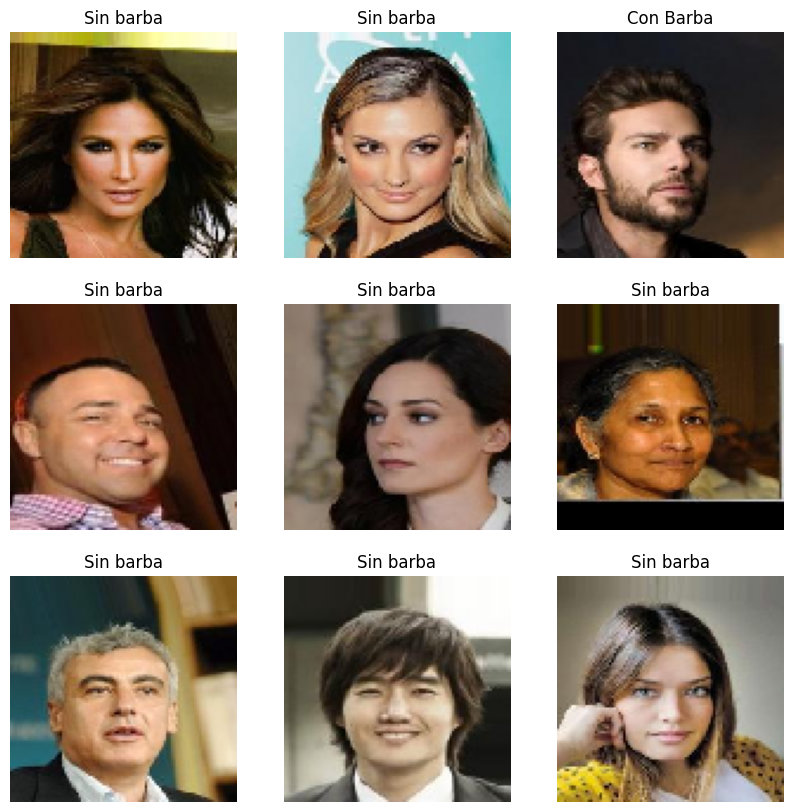

In [16]:
sample_images(test)

# Machine Learning

In [17]:
# Funciones a utilizar durante el entrenamiento para luego evaluar los modelos
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [18]:
def learning_curve(history):
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='validation')
  plt.title('Accuracy over train epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()

In [128]:
datasets = (
    ('train', datagen.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS, batch_size=1000)),
    ('validation', datagen.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS, batch_size=1000)),
)

def print_cofusion_matrix(model):
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        batch_images, batch_labels = dataset.next()
        print('Samples:', len(batch_images))

        predictions = np.round(model.predict(batch_images)).flatten()
        labels = batch_labels
        
        print('Accuracy:', accuracy_score(labels, predictions))
        print('Precision:', precision_score(labels, predictions))
        print('ROC-AUC Score:', roc_auc_score(labels,predictions))

        VALORES = "Beard", "No Beard"
        
        plt.figure(figsize=(6,6))
        
        sns.heatmap(confusion_matrix(labels, predictions), annot=True, cmap='Greens', xticklabels=VALORES, yticklabels=VALORES, fmt='g')
        plt.xlabel('Predicted value')
        plt.ylabel('True value')
        plt.title('Confusion Matrix')
        plt.show()

In [20]:
def set_model_best_weight(history, model):
    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    model.set_weights(model_weights_at_epochs[best_val_acc_epoch])
    print('Mejor época:',best_val_acc_epoch)
    print('val_accuracy:',history.history['val_accuracy'][best_val_acc_epoch])

In [21]:
BATCH_SIZE = 64

COMPILE_PARAMS = dict(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# Obtengo el peso que le vamos a asignar a cada clase a la hora de entrenar, para manejar el desbalance del target
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(train.classes),y=train.classes)
class_weights = dict(zip(np.unique(train.classes), class_weights))

FIT_PARAMS = dict(
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train)/BATCH_SIZE,
    validation_steps=len(validation)/BATCH_SIZE,
    validation_data=validation,
    callbacks=[OurCustomCallback()],
    class_weight = class_weights,
)

## Multi Layer Perceptron



In [22]:
# MLP

mlp_1_1 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(100, activation='relu'),
    Dropout(0.25),
                                                # aca buscamos ver si hay mucha diferencia entre las funciones de activacion
    Dense(1, activation='sigmoid'),
])

mlp_1_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

mlp_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),), # a este modelo lo vamos a entrenar dos veces, una vez con 10 y otra con 20 epocas

    Dense(50, activation='relu'),
    Dropout(0.25),
    Dense(50, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

mlp_3 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(60, activation='relu'),
    Dropout(0.25),
    Dense(40, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])
                                                # aca probamos otros modelos con mas capas ocultas para ver como funciona
mlp_4 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [23]:
# Compilamos cada uno de los modelos MLP planteados y vemos el resumen
mlp_1_1.compile(**COMPILE_PARAMS) #relu

mlp_1_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 100)               2764900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_mlp_1_1 = mlp_1_1.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 38s 454ms/step - loss: 1.8997 - accuracy: 0.5336 - val_loss: 0.6944 - val_accuracy: 0.2750
Epoch 2/15
79/79 [==============================] - 35s 446ms/step - loss: 0.7132 - accuracy: 0.5051 - val_loss: 0.6426 - val_accuracy: 0.8344
Epoch 3/15
79/79 [==============================] - 35s 442ms/step - loss: 0.6504 - accuracy: 0.6375 - val_loss: 0.5979 - val_accuracy: 0.7375
Epoch 4/15
79/79 [==============================] - 36s 451ms/step - loss: 0.6629 - accuracy: 0.6117 - val_loss: 0.6354 - val_accuracy: 0.5906
Epoch 5/15
79/79 [==============================] - 34s 429ms/step - loss: 0.6299 - accuracy: 0.5820 - val_loss: 0.5086 - val_accuracy: 0.7750
Epoch 6/15
79/79 [==============================] - 34s 428ms/step - loss: 0.6642 - accuracy: 0.5262 - val_loss: 0.6433 - val_accuracy: 0.5188
Epoch 7/15
79/79 [==============================] - 34s 422ms/step - loss: 0.6251 - accuracy: 0.5902 - val_loss: 0.4589 - val_accuracy: 0.8219

In [25]:
#set_model_best_weight(history_mlp_1_1, mlp_1_1)

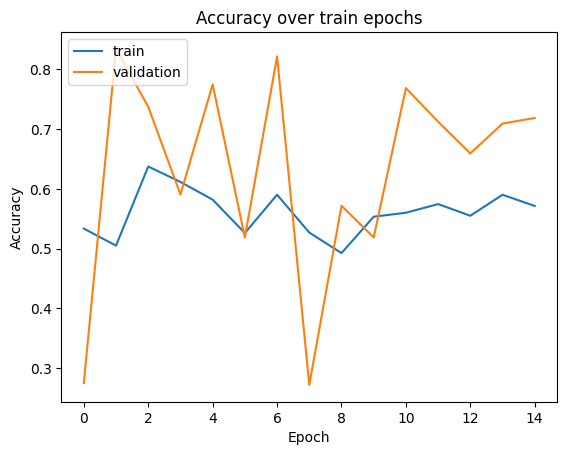

In [26]:
learning_curve(history_mlp_1_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.692
Precision: 0.9625668449197861
ROC-AUC Score: 0.7657876159389394


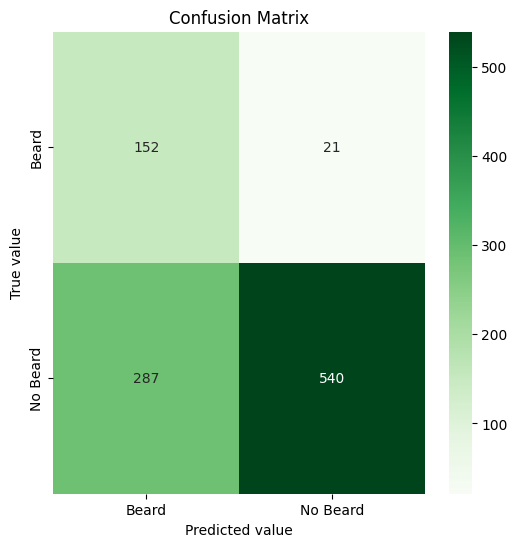

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.684
Precision: 0.9522968197879859
ROC-AUC Score: 0.7469947196944162


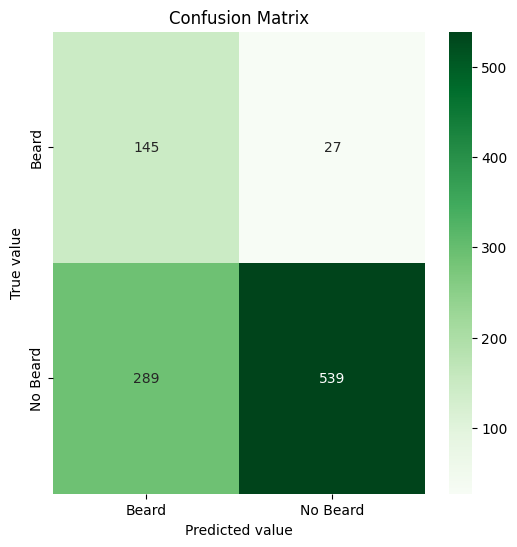

In [129]:
print_cofusion_matrix(mlp_1_1)

In [28]:
# Guardamos los pesos de la ultima epoca
mlp_1_1.save_weights("mlp_1_1.h5")

In [29]:
mlp_1_2.compile(**COMPILE_PARAMS) #tanh

mlp_1_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 27648)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               2764900   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [30]:
history_mlp_1_2 = mlp_1_2.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 31s 384ms/step - loss: 2.6673 - accuracy: 0.8164 - val_loss: 0.5266 - val_accuracy: 0.8031
Epoch 2/15
79/79 [==============================] - 30s 384ms/step - loss: 0.7506 - accuracy: 0.4961 - val_loss: 0.6615 - val_accuracy: 0.8500
Epoch 3/15
79/79 [==============================] - 30s 374ms/step - loss: 0.7469 - accuracy: 0.5039 - val_loss: 0.7107 - val_accuracy: 0.1719
Epoch 4/15
79/79 [==============================] - 30s 376ms/step - loss: 0.7608 - accuracy: 0.4609 - val_loss: 0.7114 - val_accuracy: 0.1594
Epoch 5/15
79/79 [==============================] - 29s 366ms/step - loss: 0.7421 - accuracy: 0.4969 - val_loss: 0.6756 - val_accuracy: 0.4563
Epoch 6/15
79/79 [==============================] - 28s 358ms/step - loss: 0.7294 - accuracy: 0.4965 - val_loss: 0.6876 - val_accuracy: 0.7937
Epoch 7/15
79/79 [==============================] - 28s 354ms/step - loss: 0.7159 - accuracy: 0.5254 - val_loss: 0.6789 - val_accuracy: 0.8031

In [31]:
#set_model_best_weight(history_mlp_1_2, mlp_1_2)

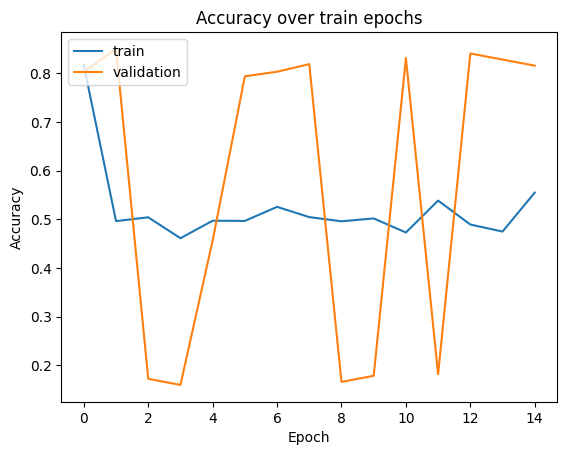

In [32]:
learning_curve(history_mlp_1_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.838
Precision: 0.838
ROC-AUC Score: 0.5


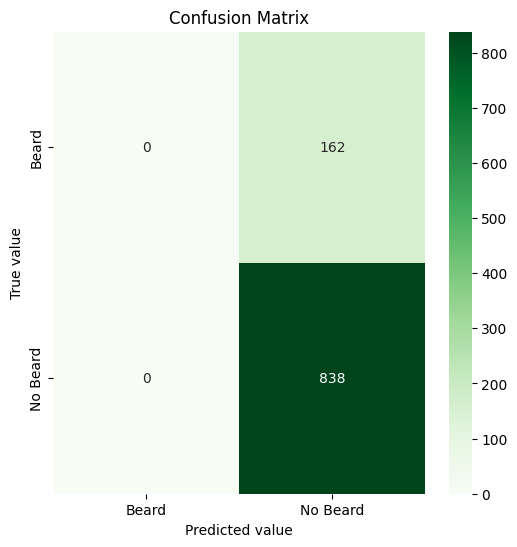

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.834
Precision: 0.834
ROC-AUC Score: 0.5


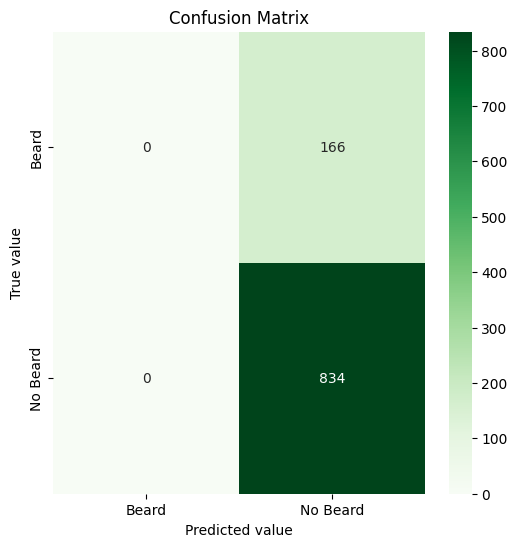

In [130]:
print_cofusion_matrix(mlp_1_2)

In [34]:
mlp_1_2.save_weights("mlp_1_2.h5")

In [35]:
mlp_2.compile(**COMPILE_PARAMS)

mlp_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 27648)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                1382450   
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,385,051
Trainable params: 1,385,051
No

In [36]:
history_mlp_2_1 = mlp_2.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 26s 314ms/step - loss: 1.7704 - accuracy: 0.5934 - val_loss: 0.6939 - val_accuracy: 0.1594
Epoch 2/20
79/79 [==============================] - 24s 306ms/step - loss: 0.6845 - accuracy: 0.1734 - val_loss: 0.6933 - val_accuracy: 0.1625
Epoch 3/20
79/79 [==============================] - 25s 312ms/step - loss: 0.7047 - accuracy: 0.7891 - val_loss: 0.6912 - val_accuracy: 0.8281
Epoch 4/20
79/79 [==============================] - 23s 287ms/step - loss: 0.6896 - accuracy: 0.8359 - val_loss: 0.6888 - val_accuracy: 0.8375
Epoch 5/20
79/79 [==============================] - 25s 308ms/step - loss: 0.6609 - accuracy: 0.8531 - val_loss: 0.6846 - val_accuracy: 0.8313
Epoch 6/20
79/79 [==============================] - 24s 298ms/step - loss: 0.7003 - accuracy: 0.8301 - val_loss: 0.6862 - val_accuracy: 0.8188
Epoch 7/20
79/79 [==============================] - 22s 276ms/step - loss: 0.6982 - accuracy: 0.8313 - val_loss: 0.6887 - val_accuracy: 0.8500

In [37]:
#set_model_best_weight(history_mlp_2_1, mlp_2)

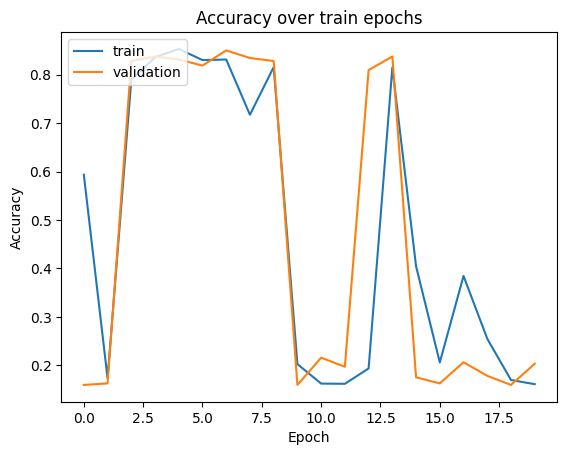

In [38]:
learning_curve(history_mlp_2_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.836
Precision: 0.836
ROC-AUC Score: 0.5


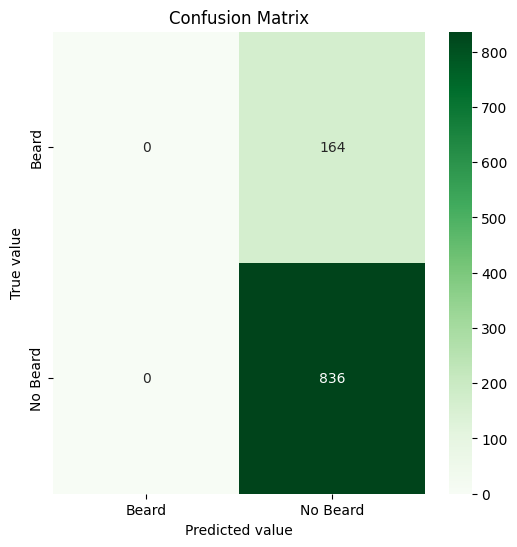

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.823
Precision: 0.823
ROC-AUC Score: 0.5


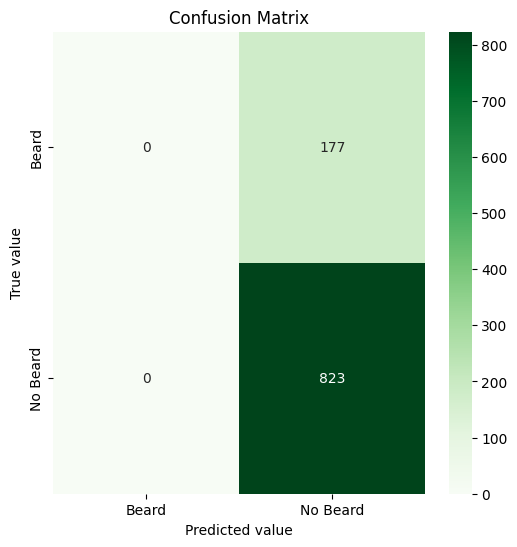

In [131]:
print_cofusion_matrix(mlp_2)

In [40]:
mlp_2.save_weights("mlp_2_1.h5")

In [41]:
mlp_2.compile(**COMPILE_PARAMS)

mlp_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 27648)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                1382450   
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,385,051
Trainable params: 1,385,051
No

In [42]:
history_mlp_2_2 = mlp_2.fit(
    train,
    epochs=40,
    **FIT_PARAMS
)

Epoch 1/40
79/79 [==============================] - 20s 240ms/step - loss: 0.6877 - accuracy: 0.2520 - val_loss: 0.6944 - val_accuracy: 0.1406
Epoch 2/40
79/79 [==============================] - 19s 233ms/step - loss: 0.7000 - accuracy: 0.2484 - val_loss: 0.6959 - val_accuracy: 0.1844
Epoch 3/40
79/79 [==============================] - 18s 226ms/step - loss: 0.6898 - accuracy: 0.4035 - val_loss: 0.6931 - val_accuracy: 0.8250
Epoch 4/40
79/79 [==============================] - 19s 235ms/step - loss: 0.6885 - accuracy: 0.4973 - val_loss: 0.6924 - val_accuracy: 0.8219
Epoch 5/40
79/79 [==============================] - 18s 233ms/step - loss: 0.6823 - accuracy: 0.6684 - val_loss: 0.6894 - val_accuracy: 0.8594
Epoch 6/40
79/79 [==============================] - 18s 223ms/step - loss: 0.6675 - accuracy: 0.8492 - val_loss: 0.6829 - val_accuracy: 0.8219
Epoch 7/40
79/79 [==============================] - 18s 231ms/step - loss: 0.6936 - accuracy: 0.8340 - val_loss: 0.6831 - val_accuracy: 0.8313

In [43]:
#set_model_best_weight(history_mlp_2_2, mlp_2)

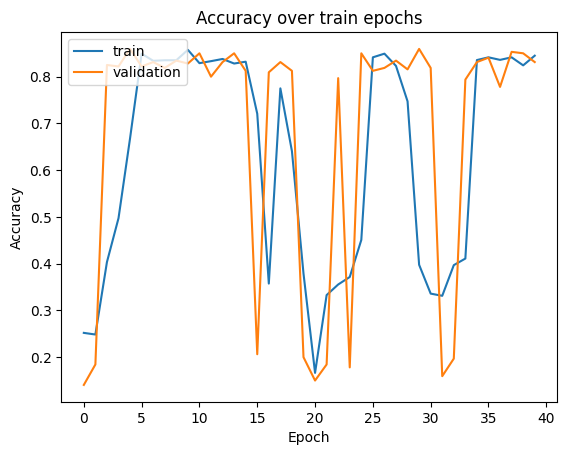

In [44]:
learning_curve(history_mlp_2_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.844
Precision: 0.844
ROC-AUC Score: 0.5


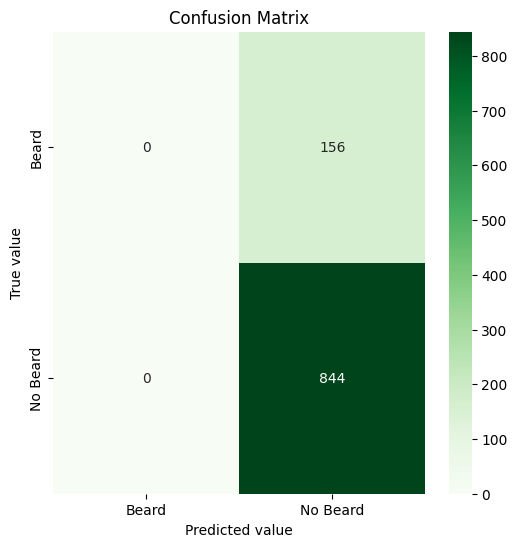

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.845
Precision: 0.845
ROC-AUC Score: 0.5


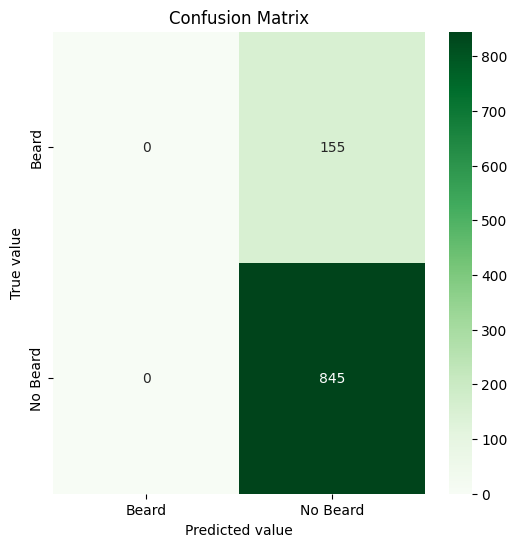

In [132]:
print_cofusion_matrix(mlp_2)

In [46]:
mlp_2.save_weights("mlp_2_2.h5")

In [47]:
mlp_3.compile(**COMPILE_PARAMS)

mlp_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 27648)             0         
                                                                 
 dense_7 (Dense)             (None, 60)                1658940   
                                                                 
 dropout_4 (Dropout)         (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 40)                2440      
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                820       
                                                                 
 dropout_6 (Dropout)         (None, 20)               

In [48]:
history_mlp_3 = mlp_3.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 12s 138ms/step - loss: 1.2224 - accuracy: 0.3562 - val_loss: 0.6975 - val_accuracy: 0.1594
Epoch 2/15
79/79 [==============================] - 11s 141ms/step - loss: 0.6622 - accuracy: 0.4660 - val_loss: 0.6902 - val_accuracy: 0.8438
Epoch 3/15
79/79 [==============================] - 11s 144ms/step - loss: 0.6856 - accuracy: 0.8387 - val_loss: 0.6891 - val_accuracy: 0.8406
Epoch 4/15
79/79 [==============================] - 11s 136ms/step - loss: 0.6929 - accuracy: 0.8340 - val_loss: 0.6894 - val_accuracy: 0.8531
Epoch 5/15
79/79 [==============================] - 10s 127ms/step - loss: 0.6736 - accuracy: 0.8457 - val_loss: 0.6873 - val_accuracy: 0.7500
Epoch 6/15
79/79 [==============================] - 10s 123ms/step - loss: 0.6802 - accuracy: 0.8418 - val_loss: 0.6850 - val_accuracy: 0.8031
Epoch 7/15
79/79 [==============================] - 10s 128ms/step - loss: 0.6842 - accuracy: 0.8395 - val_loss: 0.6840 - val_accuracy: 0.7969

In [49]:
#set_model_best_weight(history_mlp_3, mlp_3)

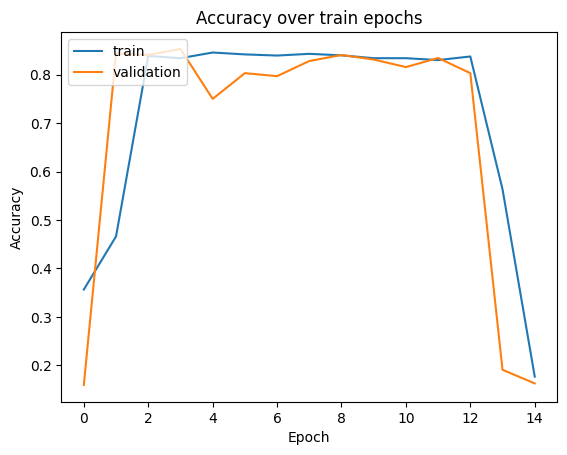

In [50]:
learning_curve(history_mlp_3)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.187
Precision: 0.0
ROC-AUC Score: 0.5


D:\HDD_Documents\Universidad\En_curso\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


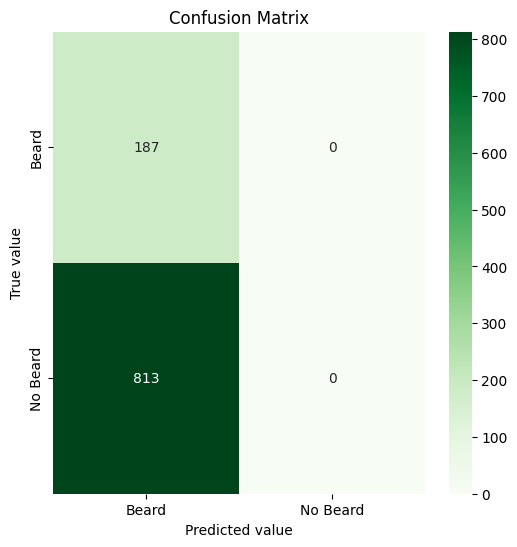

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.181
Precision: 0.0
ROC-AUC Score: 0.5


D:\HDD_Documents\Universidad\En_curso\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


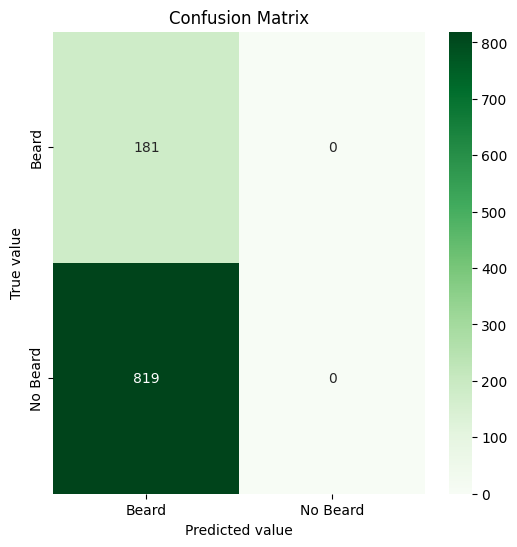

In [133]:
print_cofusion_matrix(mlp_3)

In [52]:
mlp_3.save_weights("mlp_3.h5")

In [53]:
mlp_4.compile(**COMPILE_PARAMS)

mlp_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 27648)             0         
                                                                 
 dense_11 (Dense)            (None, 20)                552980    
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dropout_9 (Dropout)         (None, 20)               

In [54]:
history_mlp_4 = mlp_4.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 9s 95ms/step - loss: 0.7739 - accuracy: 0.2801 - val_loss: 0.6975 - val_accuracy: 0.1719
Epoch 2/20
79/79 [==============================] - 9s 111ms/step - loss: 0.7185 - accuracy: 0.2203 - val_loss: 0.7110 - val_accuracy: 0.1844
Epoch 3/20
79/79 [==============================] - 9s 111ms/step - loss: 0.7009 - accuracy: 0.1707 - val_loss: 0.7036 - val_accuracy: 0.1969
Epoch 4/20
79/79 [==============================] - 9s 118ms/step - loss: 0.7001 - accuracy: 0.1875 - val_loss: 0.7051 - val_accuracy: 0.1937
Epoch 5/20
79/79 [==============================] - 8s 105ms/step - loss: 0.7054 - accuracy: 0.2000 - val_loss: 0.7029 - val_accuracy: 0.1656
Epoch 6/20
79/79 [==============================] - 8s 102ms/step - loss: 0.6854 - accuracy: 0.2047 - val_loss: 0.6936 - val_accuracy: 0.1813
Epoch 7/20
79/79 [==============================] - 9s 107ms/step - loss: 0.6936 - accuracy: 0.2055 - val_loss: 0.6949 - val_accuracy: 0.1594
Epoch 8

In [55]:
#set_model_best_weight(history_mlp_4, mlp_4)

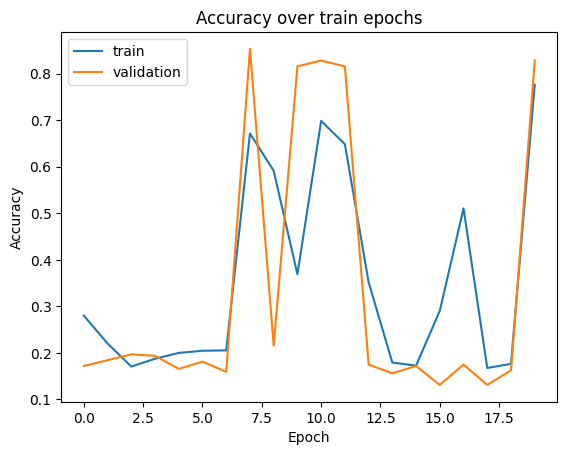

In [56]:
learning_curve(history_mlp_4)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 2ms/step
Accuracy: 0.826
Precision: 0.826
ROC-AUC Score: 0.5


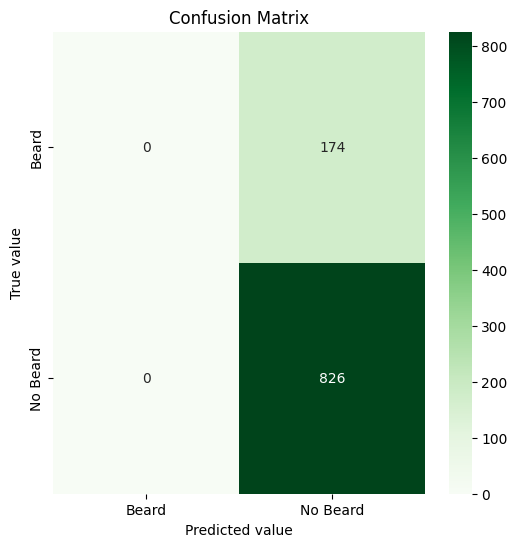

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 2ms/step
Accuracy: 0.801
Precision: 0.801
ROC-AUC Score: 0.5


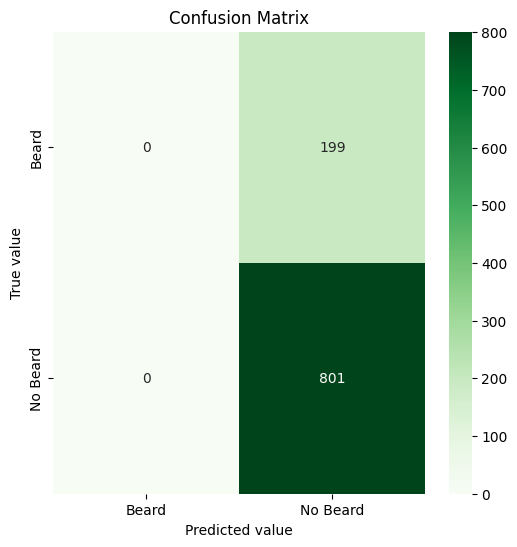

In [134]:
print_cofusion_matrix(mlp_4)

In [58]:
mlp_4.save_weights("mlp_4.h5")

# Convolutional Neural Networks

In [60]:
# CNN
cnn_1_1 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_1_2 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=32, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_2_1 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(3, 3)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_2_2 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(3, 3)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_3 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=6, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [61]:
cnn_1_1.compile(**COMPILE_PARAMS)

cnn_1_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 16)        1216      
                                                                 
 dropout_14 (Dropout)        (None, 92, 92, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 flatten_5 (Flatten)         (None, 8464)              0         
                                                                 
 dense_19 (Dense)            (None, 100)               846500    
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                      

In [62]:
history_cnn_1_1 = cnn_1_1.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 10s 110ms/step - loss: 0.7821 - accuracy: 0.4512 - val_loss: 0.6654 - val_accuracy: 0.6000
Epoch 2/20
79/79 [==============================] - 8s 100ms/step - loss: 0.5971 - accuracy: 0.6641 - val_loss: 0.5148 - val_accuracy: 0.7563
Epoch 3/20
79/79 [==============================] - 9s 108ms/step - loss: 0.5244 - accuracy: 0.7164 - val_loss: 0.5323 - val_accuracy: 0.7281
Epoch 4/20
79/79 [==============================] - 8s 101ms/step - loss: 0.4748 - accuracy: 0.7480 - val_loss: 0.5279 - val_accuracy: 0.7344
Epoch 5/20
79/79 [==============================] - 8s 106ms/step - loss: 0.4399 - accuracy: 0.7641 - val_loss: 0.4047 - val_accuracy: 0.7969
Epoch 6/20
79/79 [==============================] - 8s 99ms/step - loss: 0.4209 - accuracy: 0.7848 - val_loss: 0.4265 - val_accuracy: 0.7812
Epoch 7/20
79/79 [==============================] - 9s 109ms/step - loss: 0.4011 - accuracy: 0.8012 - val_loss: 0.4652 - val_accuracy: 0.7563
Epoch 

In [63]:
#set_model_best_weight(history_cnn_1_1, cnn_1_1)

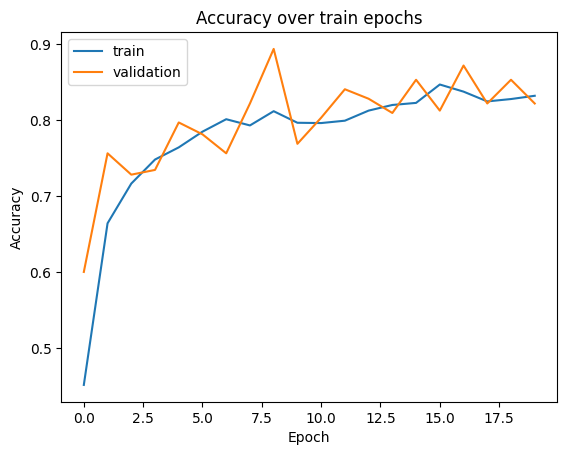

In [64]:
learning_curve(history_cnn_1_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 14ms/step
Accuracy: 0.812
Precision: 0.9789473684210527
ROC-AUC Score: 0.8545454545454546


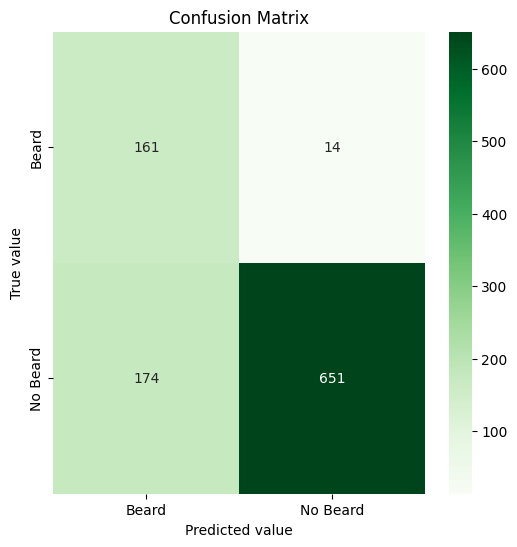

######################### validation #########################
Samples: 867
28/28 [==============================] - 0s 12ms/step
Accuracy: 0.8154555940023068
Precision: 0.9749582637729549
ROC-AUC Score: 0.8462008707580366


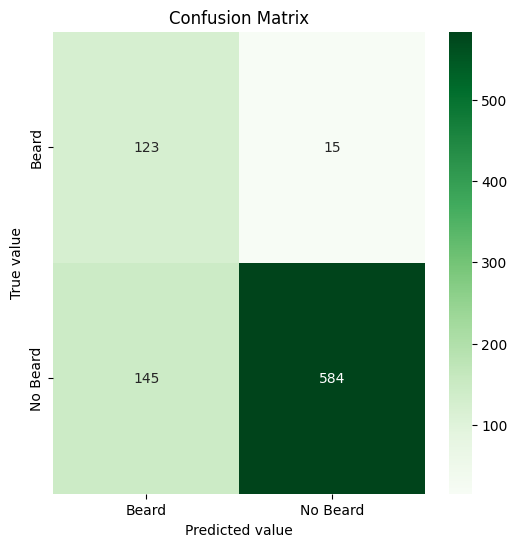

In [135]:
print_cofusion_matrix(cnn_1_1)

In [66]:
cnn_1_1.save_weights("cnn_1_1.h5")

In [67]:
cnn_1_2.compile(**COMPILE_PARAMS)

cnn_1_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        2432      
                                                                 
 dropout_16 (Dropout)        (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 16928)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               1692900   
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                      

In [68]:
history_cnn_1_2 = cnn_1_2.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 12s 142ms/step - loss: 0.7352 - accuracy: 0.5508 - val_loss: 0.6131 - val_accuracy: 0.7437
Epoch 2/15
79/79 [==============================] - 11s 134ms/step - loss: 0.5913 - accuracy: 0.6859 - val_loss: 0.6565 - val_accuracy: 0.6562
Epoch 3/15
79/79 [==============================] - 10s 127ms/step - loss: 0.5369 - accuracy: 0.7102 - val_loss: 0.4604 - val_accuracy: 0.8031
Epoch 4/15
79/79 [==============================] - 10s 130ms/step - loss: 0.4642 - accuracy: 0.7598 - val_loss: 0.4530 - val_accuracy: 0.8062
Epoch 5/15
79/79 [==============================] - 10s 128ms/step - loss: 0.4216 - accuracy: 0.7809 - val_loss: 0.3340 - val_accuracy: 0.8375
Epoch 6/15
79/79 [==============================] - 10s 126ms/step - loss: 0.4561 - accuracy: 0.7578 - val_loss: 0.3504 - val_accuracy: 0.8375
Epoch 7/15
79/79 [==============================] - 10s 127ms/step - loss: 0.4114 - accuracy: 0.7836 - val_loss: 0.3496 - val_accuracy: 0.8281

In [69]:
#set_model_best_weight(history_cnn_1_2, cnn_1_2)

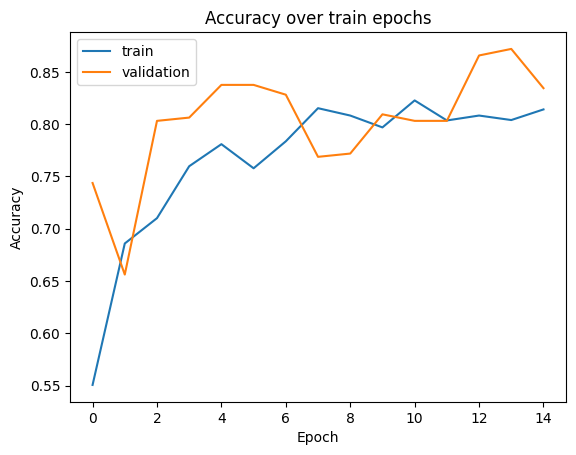

In [70]:
learning_curve(history_cnn_1_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 17ms/step
Accuracy: 0.829
Precision: 0.9782608695652174
ROC-AUC Score: 0.8617584858906714


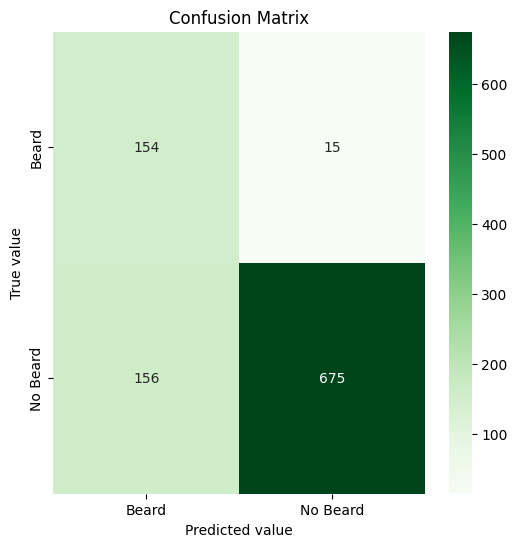

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 16ms/step
Accuracy: 0.826
Precision: 0.9747774480712166
ROC-AUC Score: 0.8578637288314708


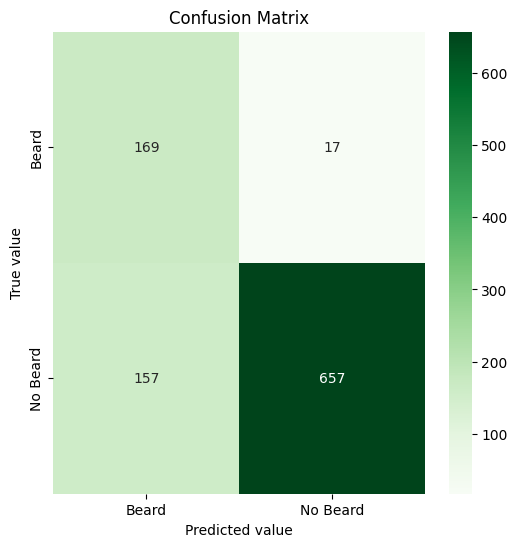

In [136]:
print_cofusion_matrix(cnn_1_2)

In [72]:
cnn_1_2.save_weights("cnn_1_2.h5")

In [73]:
cnn_2_1.compile(**COMPILE_PARAMS)

cnn_2_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 8)         224       
                                                                 
 dropout_18 (Dropout)        (None, 94, 94, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 8)         584       
                                                                 
 dropout_19 (Dropout)        (None, 92, 92, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 8)         584       
                                                                 
 dropout_20 (Dropout)        (None, 90, 90, 8)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 8)       

In [74]:
history_cnn_2_1 = cnn_2_1.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 13s 151ms/step - loss: 0.8756 - accuracy: 0.5176 - val_loss: 0.6941 - val_accuracy: 0.2281
Epoch 2/20
79/79 [==============================] - 12s 149ms/step - loss: 0.6829 - accuracy: 0.6555 - val_loss: 0.6976 - val_accuracy: 0.2500
Epoch 3/20
79/79 [==============================] - 12s 151ms/step - loss: 0.6312 - accuracy: 0.6824 - val_loss: 0.6973 - val_accuracy: 0.3375
Epoch 4/20
79/79 [==============================] - 13s 169ms/step - loss: 0.6049 - accuracy: 0.6941 - val_loss: 0.6896 - val_accuracy: 0.4969
Epoch 5/20
79/79 [==============================] - 14s 170ms/step - loss: 0.5614 - accuracy: 0.7059 - val_loss: 0.6909 - val_accuracy: 0.5094
Epoch 6/20
79/79 [==============================] - 13s 163ms/step - loss: 0.6026 - accuracy: 0.6711 - val_loss: 0.7026 - val_accuracy: 0.4688
Epoch 7/20
79/79 [==============================] - 13s 165ms/step - loss: 0.5225 - accuracy: 0.7457 - val_loss: 0.7013 - val_accuracy: 0.5000

In [75]:
#set_model_best_weight(history_cnn_2_1, cnn_2_1)

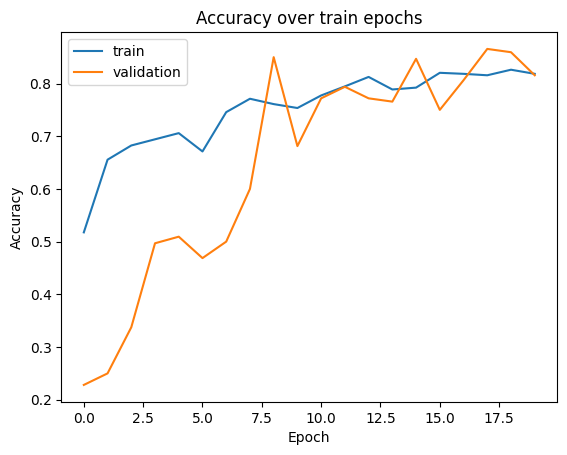

In [76]:
learning_curve(history_cnn_2_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 20ms/step
Accuracy: 0.797
Precision: 0.956140350877193
ROC-AUC Score: 0.808699876285201


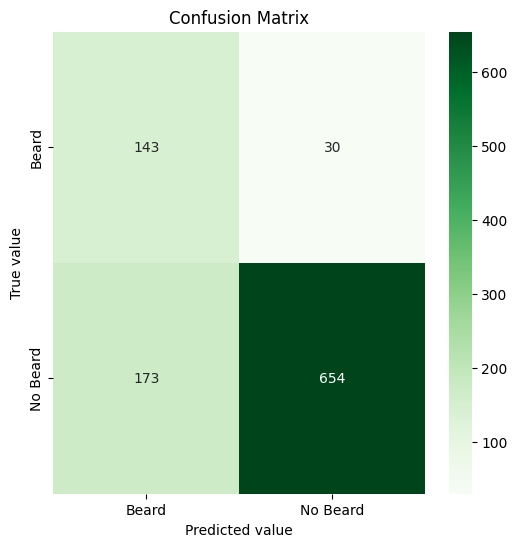

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 22ms/step
Accuracy: 0.84
Precision: 0.9659090909090909
ROC-AUC Score: 0.8514492753623188


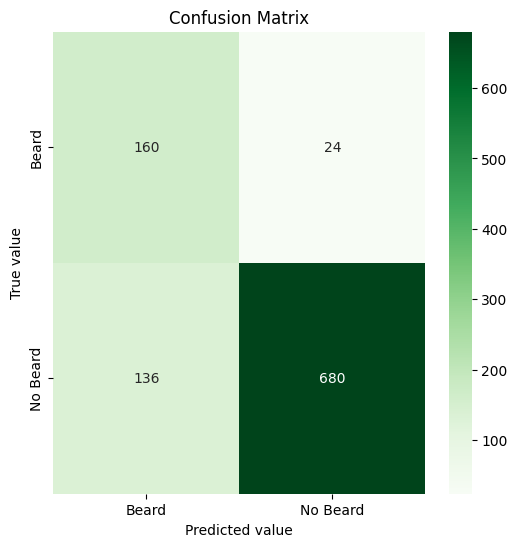

In [137]:
print_cofusion_matrix(cnn_2_1)

In [78]:
cnn_2_1.save_weights("cnn_2_1.h5")

In [79]:
cnn_2_2.compile(**COMPILE_PARAMS)

cnn_2_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 90, 90, 8)         1184      
                                                                 
 dropout_22 (Dropout)        (None, 90, 90, 8)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 84, 84, 8)         3144      
                                                                 
 dropout_23 (Dropout)        (None, 84, 84, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 8)         3144      
                                                                 
 dropout_24 (Dropout)        (None, 78, 78, 8)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 8)       

In [80]:
history_cnn_2_2 = cnn_2_2.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 29s 347ms/step - loss: 0.6844 - accuracy: 0.6027 - val_loss: 0.7027 - val_accuracy: 0.1656
Epoch 2/20
79/79 [==============================] - 27s 345ms/step - loss: 0.6672 - accuracy: 0.6160 - val_loss: 0.6746 - val_accuracy: 0.6469
Epoch 3/20
79/79 [==============================] - 28s 348ms/step - loss: 0.5789 - accuracy: 0.7102 - val_loss: 0.6208 - val_accuracy: 0.7500
Epoch 4/20
79/79 [==============================] - 28s 345ms/step - loss: 0.4928 - accuracy: 0.7652 - val_loss: 0.4699 - val_accuracy: 0.7969
Epoch 5/20
79/79 [==============================] - 28s 345ms/step - loss: 0.4353 - accuracy: 0.7941 - val_loss: 0.4201 - val_accuracy: 0.8281
Epoch 6/20
79/79 [==============================] - 27s 344ms/step - loss: 0.4121 - accuracy: 0.8133 - val_loss: 0.4599 - val_accuracy: 0.7563
Epoch 7/20
79/79 [==============================] - 28s 345ms/step - loss: 0.3860 - accuracy: 0.8195 - val_loss: 0.4177 - val_accuracy: 0.7937

In [81]:
#set_model_best_weight(history_cnn_2_2, cnn_2_2)

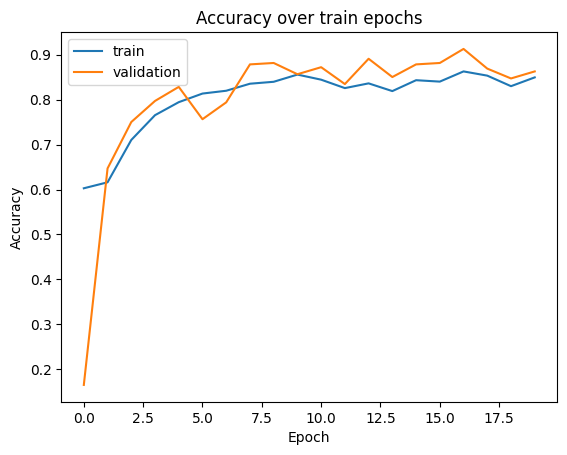

In [82]:
learning_curve(history_cnn_2_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 37ms/step
Accuracy: 0.858
Precision: 0.9735006973500697
ROC-AUC Score: 0.8720187263114202


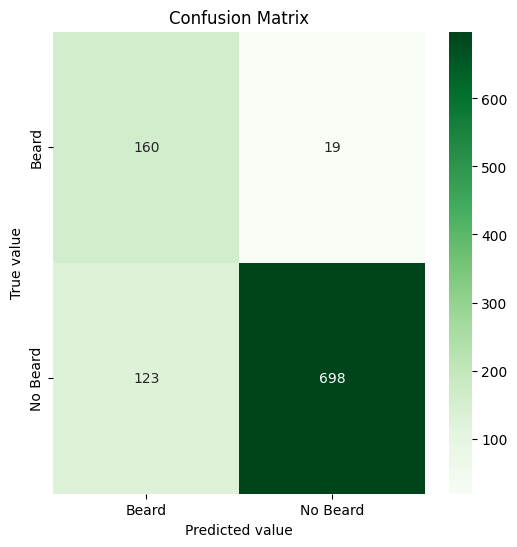

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 37ms/step
Accuracy: 0.86
Precision: 0.9695290858725761
ROC-AUC Score: 0.8674333001961363


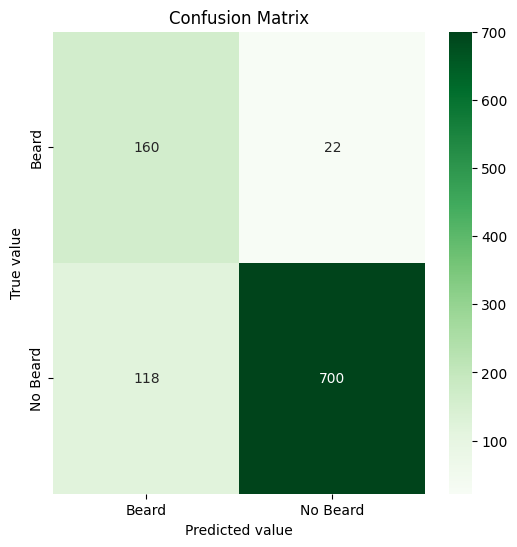

In [138]:
print_cofusion_matrix(cnn_2_2)

In [84]:
cnn_2_2.save_weights("cnn_2_2.h5")

In [85]:
cnn_3.compile(**COMPILE_PARAMS)

cnn_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 92, 92, 6)         456       
                                                                 
 dropout_26 (Dropout)        (None, 92, 92, 6)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 46, 46, 6)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 dropout_27 (Dropout)        (None, 21, 21, 16)       

In [86]:
history_cnn_3 = cnn_3.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 8s 88ms/step - loss: 0.7091 - accuracy: 0.5699 - val_loss: 0.6915 - val_accuracy: 0.5219
Epoch 2/20
79/79 [==============================] - 7s 86ms/step - loss: 0.6964 - accuracy: 0.5066 - val_loss: 0.6867 - val_accuracy: 0.5781
Epoch 3/20
79/79 [==============================] - 7s 88ms/step - loss: 0.6140 - accuracy: 0.6504 - val_loss: 0.5482 - val_accuracy: 0.7375
Epoch 4/20
79/79 [==============================] - 7s 88ms/step - loss: 0.5114 - accuracy: 0.7406 - val_loss: 0.4106 - val_accuracy: 0.7937
Epoch 5/20
79/79 [==============================] - 7s 87ms/step - loss: 0.4602 - accuracy: 0.7621 - val_loss: 0.4232 - val_accuracy: 0.8219
Epoch 6/20
79/79 [==============================] - 7s 86ms/step - loss: 0.4245 - accuracy: 0.7684 - val_loss: 0.3987 - val_accuracy: 0.8000
Epoch 7/20
79/79 [==============================] - 7s 86ms/step - loss: 0.4181 - accuracy: 0.7711 - val_loss: 0.3732 - val_accuracy: 0.7937
Epoch 8/20
79

In [87]:
#set_model_best_weight(history_cnn_3, cnn_3)

In [88]:
best_val_acc_epoch = np.argmax(history_cnn_3.history['val_accuracy'])
cnn_3.set_weights(model_weights_at_epochs[best_val_acc_epoch])

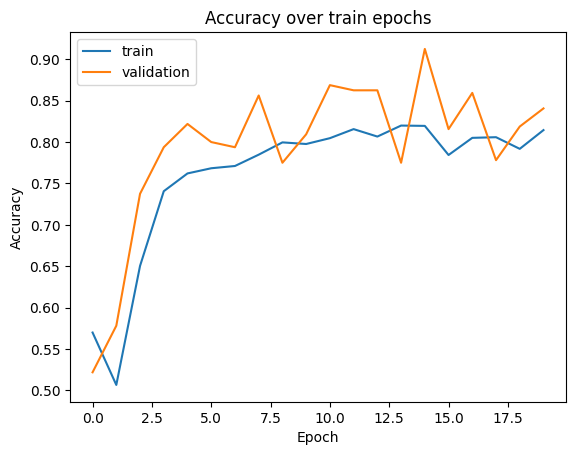

In [89]:
learning_curve(history_cnn_3)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 14ms/step
Accuracy: 0.902
Precision: 0.9631979695431472
ROC-AUC Score: 0.8740310077519379


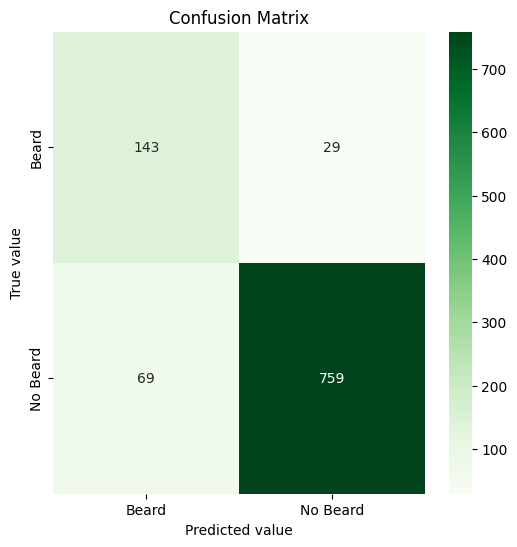

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 18ms/step
Accuracy: 0.883
Precision: 0.9335006273525721
ROC-AUC Score: 0.822375206270627


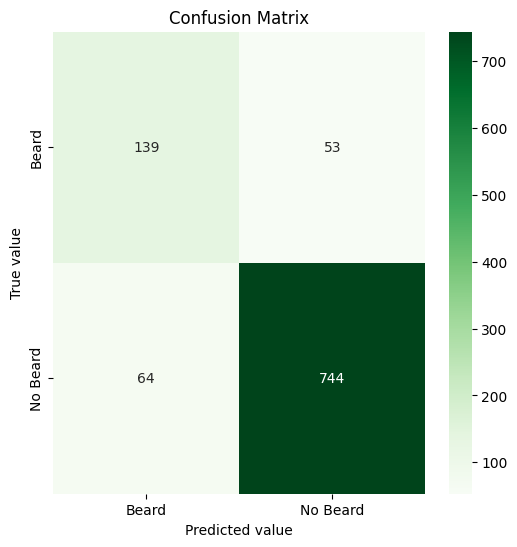

In [139]:
print_cofusion_matrix(cnn_3)

In [91]:
cnn_3.save_weights("cnn_3.h5")

## Pre-Trained Model

In [92]:
### VGG16
vgg16_model = VGG16(input_shape=(SIZE,SIZE,3), include_top=False)
vgg16_model.trainable = False

pre_trained_model_vgg16 = Sequential([
    vgg16_model,

    Flatten(),

    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid'),
])

In [93]:
pre_trained_model_vgg16.compile(**COMPILE_PARAMS)

pre_trained_model_vgg16.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 4608)              0         
                                                                 
 dense_31 (Dense)            (None, 512)               2359808   
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 257       
                                                                 
Total params: 17,206,081
Trainable params: 2,491,393


In [94]:
history_pre_trained_model_vgg16 = pre_trained_model_vgg16.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 46s 566ms/step - loss: 0.5690 - accuracy: 0.6859 - val_loss: 0.3695 - val_accuracy: 0.8219
Epoch 2/20
79/79 [==============================] - 48s 599ms/step - loss: 0.4945 - accuracy: 0.7258 - val_loss: 0.3750 - val_accuracy: 0.8000
Epoch 3/20
79/79 [==============================] - 46s 581ms/step - loss: 0.4614 - accuracy: 0.7395 - val_loss: 0.4621 - val_accuracy: 0.7375
Epoch 4/20
79/79 [==============================] - 46s 585ms/step - loss: 0.4817 - accuracy: 0.7281 - val_loss: 0.4804 - val_accuracy: 0.7344
Epoch 5/20
79/79 [==============================] - 46s 582ms/step - loss: 0.4292 - accuracy: 0.7680 - val_loss: 0.5131 - val_accuracy: 0.7188
Epoch 6/20
79/79 [==============================] - 47s 589ms/step - loss: 0.4545 - accuracy: 0.7375 - val_loss: 0.4871 - val_accuracy: 0.7250
Epoch 7/20
79/79 [==============================] - 47s 597ms/step - loss: 0.4316 - accuracy: 0.7551 - val_loss: 0.5381 - val_accuracy: 0.6938

In [95]:
#set_model_best_weight(history_pre_trained_model_vgg16, pre_trained_model_vgg16)

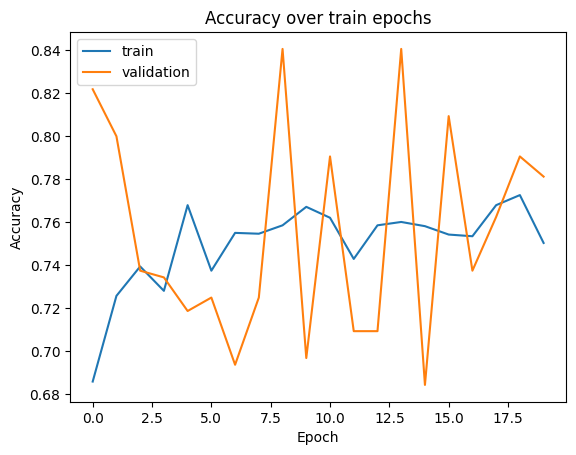

In [96]:
learning_curve(history_pre_trained_model_vgg16)

######################### train #########################
Samples: 1000
32/32 [==============================] - 16s 492ms/step
Accuracy: 0.746
Precision: 0.9730639730639731
ROC-AUC Score: 0.8106884057971016


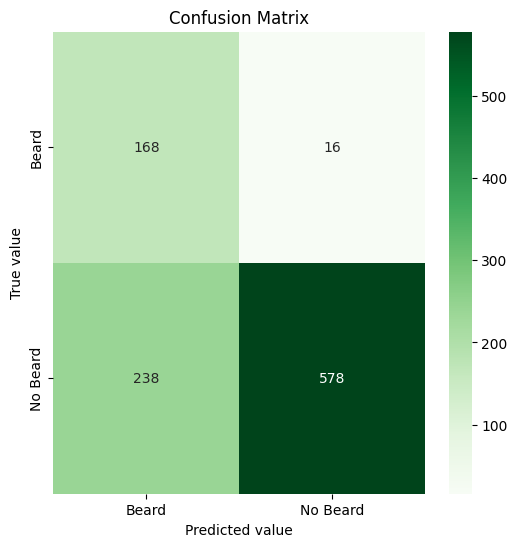

######################### validation #########################
Samples: 1000
32/32 [==============================] - 14s 441ms/step
Accuracy: 0.788
Precision: 0.9796875
ROC-AUC Score: 0.8421836297347695


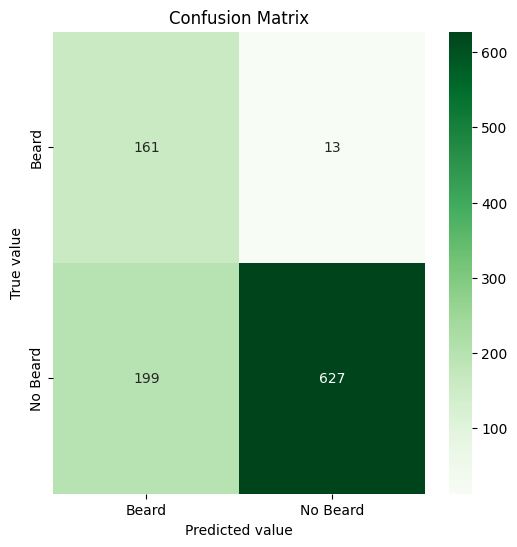

In [140]:
print_cofusion_matrix(pre_trained_model_vgg16)

In [98]:
pre_trained_model_vgg16.save_weights("pre_trained_model_vgg16.h5")

In [99]:
### Xception
xception_model = Xception(input_shape=(SIZE,SIZE,3), include_top=False)
xception_model.trainable = False

pre_trained_model_xception = Sequential([
    xception_model,

    Flatten(),

    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid'),
])

83683744/83683744 [==============================] - 7s 0us/step


In [100]:
pre_trained_model_xception.compile(**COMPILE_PARAMS)

pre_trained_model_xception.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dense_34 (Dense)            (None, 512)               9437696   
                                                                 
 dense_35 (Dense)            (None, 256)               131328    
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_36 (Dense)            (None, 1)                 257       
                                                                 
Total params: 30,430,761
Trainable params: 9,569,281


In [101]:
history_pre_trained_model_xception = pre_trained_model_xception.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 35s 405ms/step - loss: 0.8611 - accuracy: 0.6883 - val_loss: 0.4893 - val_accuracy: 0.7344
Epoch 2/20
79/79 [==============================] - 30s 377ms/step - loss: 0.5700 - accuracy: 0.7012 - val_loss: 0.4735 - val_accuracy: 0.7469
Epoch 3/20
79/79 [==============================] - 29s 359ms/step - loss: 0.5084 - accuracy: 0.7191 - val_loss: 0.7117 - val_accuracy: 0.6438
Epoch 4/20
79/79 [==============================] - 28s 348ms/step - loss: 0.4808 - accuracy: 0.7211 - val_loss: 0.3449 - val_accuracy: 0.8062
Epoch 5/20
79/79 [==============================] - 28s 354ms/step - loss: 0.4672 - accuracy: 0.7199 - val_loss: 0.3833 - val_accuracy: 0.7875
Epoch 6/20
79/79 [==============================] - 28s 356ms/step - loss: 0.4538 - accuracy: 0.7398 - val_loss: 0.3885 - val_accuracy: 0.8062
Epoch 7/20
79/79 [==============================] - 29s 358ms/step - loss: 0.4480 - accuracy: 0.7387 - val_loss: 0.4730 - val_accuracy: 0.7219

In [102]:
#set_model_best_weight(history_pre_trained_model_xception, pre_trained_model_xception)

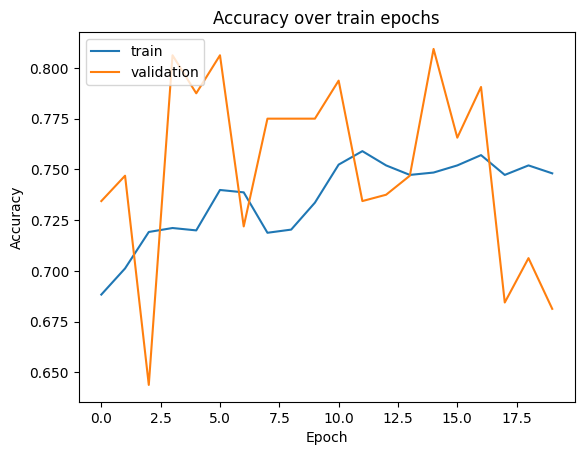

In [103]:
learning_curve(history_pre_trained_model_xception)

######################### train #########################
Samples: 1000
32/32 [==============================] - 8s 239ms/step
Accuracy: 0.717
Precision: 0.9912280701754386
ROC-AUC Score: 0.8191891258849574


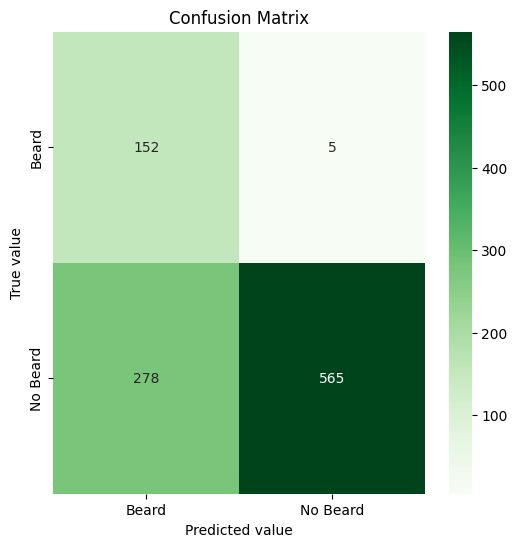

######################### validation #########################
Samples: 1000
32/32 [==============================] - 8s 240ms/step
Accuracy: 0.681
Precision: 0.990530303030303
ROC-AUC Score: 0.7970879052414773


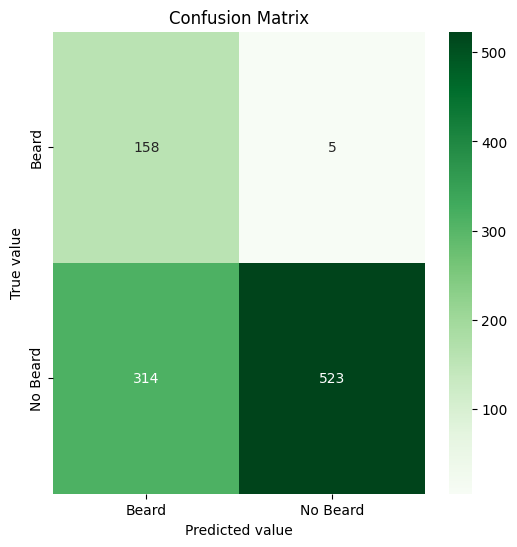

In [141]:
print_cofusion_matrix(pre_trained_model_xception)

In [105]:
pre_trained_model_xception.save_weights("pre_trained_model_xception.h5")

In [106]:
### VGG16 2
#vgg16_model = VGG16(input_shape=(SIZE,SIZE,3), include_top=False)
#vgg16_model.trainable = False

pre_trained_model_vgg16_2 = Sequential([
    vgg16_model,

    Flatten(),

    Dense(2048, activation='relu'),
    Dropout(0.25),
    Dense(1024, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [107]:
pre_trained_model_vgg16_2.compile(**COMPILE_PARAMS)

pre_trained_model_vgg16_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 4608)              0         
                                                                 
 dense_37 (Dense)            (None, 2048)              9439232   
                                                                 
 dropout_33 (Dropout)        (None, 2048)              0         
                                                                 
 dense_38 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_34 (Dropout)        (None, 1024)              0         
                                                                 
 dense_39 (Dense)            (None, 1)               

In [108]:
history_pre_trained_model_vgg16_2 = pre_trained_model_vgg16_2.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 53s 660ms/step - loss: 0.7574 - accuracy: 0.6703 - val_loss: 0.4858 - val_accuracy: 0.7531
Epoch 2/20
79/79 [==============================] - 53s 667ms/step - loss: 0.5128 - accuracy: 0.7184 - val_loss: 0.4957 - val_accuracy: 0.7312
Epoch 3/20
79/79 [==============================] - 53s 664ms/step - loss: 0.5060 - accuracy: 0.7133 - val_loss: 0.4060 - val_accuracy: 0.7688
Epoch 4/20
79/79 [==============================] - 52s 657ms/step - loss: 0.5236 - accuracy: 0.7023 - val_loss: 0.3612 - val_accuracy: 0.8281
Epoch 5/20
79/79 [==============================] - 53s 661ms/step - loss: 0.4704 - accuracy: 0.7344 - val_loss: 0.4435 - val_accuracy: 0.7688
Epoch 6/20
79/79 [==============================] - 52s 657ms/step - loss: 0.4663 - accuracy: 0.7312 - val_loss: 0.4388 - val_accuracy: 0.7594
Epoch 7/20
79/79 [==============================] - 51s 647ms/step - loss: 0.4957 - accuracy: 0.7160 - val_loss: 0.6682 - val_accuracy: 0.6313

In [109]:
#set_model_best_weight(history_pre_trained_model_vgg16, pre_trained_model_vgg16)

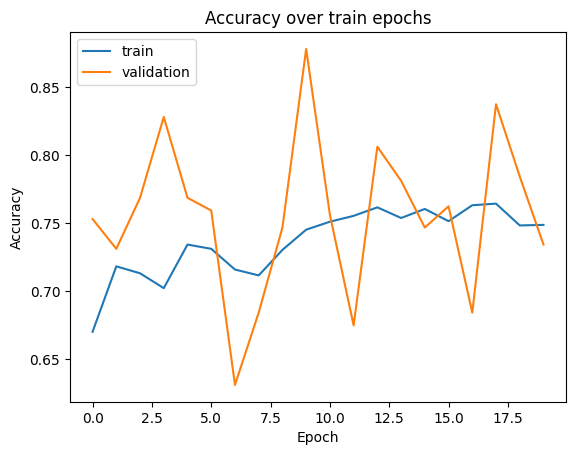

In [110]:
learning_curve(history_pre_trained_model_vgg16_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 15s 464ms/step
Accuracy: 0.762
Precision: 0.9621451104100947
ROC-AUC Score: 0.8019638128861429


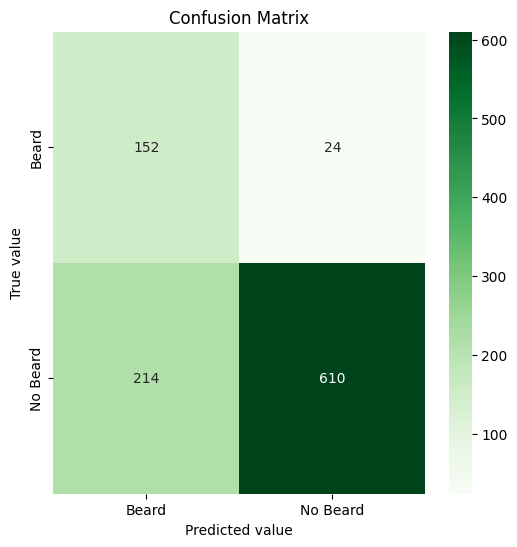

######################### validation #########################
Samples: 1000
32/32 [==============================] - 15s 478ms/step
Accuracy: 0.766
Precision: 0.9612403100775194
ROC-AUC Score: 0.8008450962549115


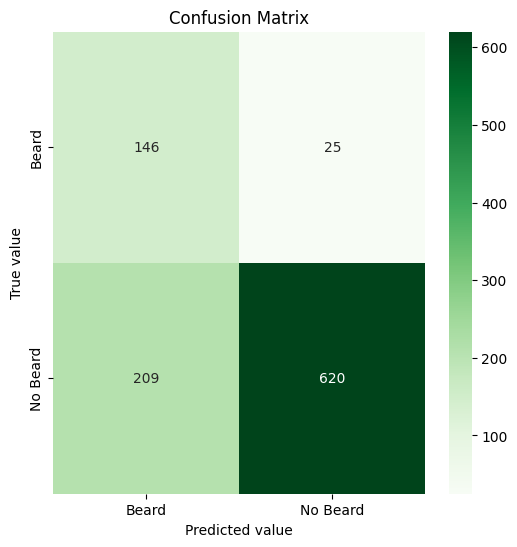

In [142]:
print_cofusion_matrix(pre_trained_model_vgg16_2)

In [112]:
pre_trained_model_vgg16_2.save_weights("pre_trained_model_vgg16_2.h5")

## Data Augmentation

### Modelo Seleccionado: X

Descripcion del modelo

Por que este modelo.

Reentrenarlo con data augmentation.